In [1]:
import tensorflow as tf
import pycocotools
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from PIL import Image
import os
import sys
import random
import cv2
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from keras.preprocessing.image import ImageDataGenerator
from pycocotools.coco import COCO

In [2]:
import skimage.io as io
## For visualizing results
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
%matplotlib inline

# Data preparation Functions:

In [3]:
def filterDataset(folder, classes=None, mode='train'):    
    # initialize COCO api for instance annotations
    annFile = '{}/annotations/instances_{}.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [4]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  
    
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask

In [5]:
def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4, mode='train', mask_type='binary'):
    
    img_folder = '{}/images/{}'.format(folder, mode)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

# Data augmentation: 
If you wanna reduce **overfitting** and **increase** the **training set size**

In [6]:
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img, mask in gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = mask_gen.flow(mask, 
                             batch_size = mask.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        img_aug = next(g_x)/255.0
        
        mask_aug = next(g_y)
                   

        yield img_aug, mask_aug

# Data generator visualizer:

In [7]:
def visualizeGenerator(gen):
    img, mask = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
                
            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()

# Testing model predict:

In [33]:
def test_model(gen, model):
    
    img, mask = next(gen)
    
    reshaped_img = img[0].reshape((1, 128,128,3))
    
    reshaped_mask = mask[0].reshape((1,128,128,1))
    
    predict = model.predict(reshaped_img)
    
    predict = predict > 0.4
    
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                    subplot_spec=outerGrid[0], wspace=0.05, hspace=0.05)

    for i in range(3):
    
        ax = plt.Subplot(fig, innerGrid[i])
        if(i==0):
            ax.imshow(img[0])
        elif(i==1):
            ax.imshow(np.reshape(reshaped_mask[0]*255, (128, 128)));
        elif(i==2):
            ax.imshow(np.reshape(predict[0]*255, (128, 128)))
                
        ax.axis('off')
        fig.add_subplot(ax) 

In [9]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = False, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

# val_gen_aug = augmentationsGenerator(val_gen, augGeneratorArgs)
# train_gen_aug = augmentationsGenerator(train_gen, augGeneratorArgs)

# Building Unet

**Convolution Block**

In [10]:
def conv_block(inputs, num_filters, dropout_rate=0.0):

    conv = Conv2D(filters=num_filters,
                  kernel_size=(3,3),
                  padding='same',
                  kernel_initializer="he_normal")(inputs)

    conv = BatchNormalization()(conv)

    conv = Activation("relu")(conv)

    if dropout_rate > 0.0:
        conv = Dropout(dropout_rate)(conv)

    conv = Conv2D(filters=num_filters,
                  kernel_size=(3,3),
                  padding='same',
                  kernel_initializer="he_normal")(conv)

    conv = BatchNormalization()(conv)

    conv = Activation("relu")(conv)

    return conv

**Encoder Block**

In [11]:
def encoder_block(inputs, num_filters, dropout_rate = 0.0):

  conv = conv_block(inputs, num_filters, dropout_rate)

  pool = MaxPool2D((2,2))(conv)

  return conv, pool

**Decoder Block**

In [12]:
def decoder_block(inputs, skip, num_filters, dropout_rate = 0.0):

  conv = Conv2DTranspose(filters = num_filters,
                         kernel_size = (2,2),
                         strides = (2,2),
                         padding = 'same',
                         kernel_initializer="he_normal")(inputs)

  conv = Concatenate()([conv, skip])

  conv = conv_block(conv, num_filters, dropout_rate)

  return conv

**Unet**

In [13]:
def Unet(input_shape = (128,128,3)):

  filter_size = [64,128,256,512,1024]

  inputs = Input(shape = input_shape)

  #Encoder:

  c1, p1 = encoder_block(inputs, filter_size[0], 0.1)
  c2, p2 = encoder_block(p1, filter_size[1], 0.1)
  c3, p3 = encoder_block(p2, filter_size[2], 0.2)
  c4, p4 = encoder_block(p3, filter_size[3], 0.2)

  #BottleNeck:

  b = conv_block(p4, filter_size[4], 0.3)

  #Decoder:

  d1 = decoder_block(b, c4, filter_size[3], 0.2)
  d2 = decoder_block(d1, c3, filter_size[2], 0.2)
  d3 = decoder_block(d2, c2, filter_size[1], 0.1)
  d4 = decoder_block(d3, c1, filter_size[0], 0.1)

  outputs = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(d4)

  model = Model(inputs, outputs, name = "UNET")

  return model

Path

In [14]:
folder = './COCOdataset2017'
model_folder = './model_file'
csv_file = './log_file.csv'

Hyperparameters

In [15]:
batch_size = 4
input_image_size = (128,128)
epochs = 30
learning_rate = 1e-4

In [16]:
classes = ['car']
val_mode = 'val'
train_mode = 'train'

val_images, val_dataset_size, val_coco = filterDataset(folder, classes,  val_mode)
train_images, train_dataset_size, train_coco = filterDataset(folder, classes,  train_mode)

loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
loading annotations into memory...
Done (t=16.09s)
creating index...
index created!


In [19]:
mask_type = 'binary'

val_gen = dataGeneratorCoco(val_images, classes, val_coco, folder,
                            input_image_size, batch_size, val_mode, mask_type)

train_gen = dataGeneratorCoco(train_images, classes, train_coco, folder,
                            input_image_size, batch_size, train_mode, mask_type)

In [20]:
val_gen_aug = augmentationsGenerator(val_gen, augGeneratorArgs)
train_gen_aug = augmentationsGenerator(train_gen, augGeneratorArgs)

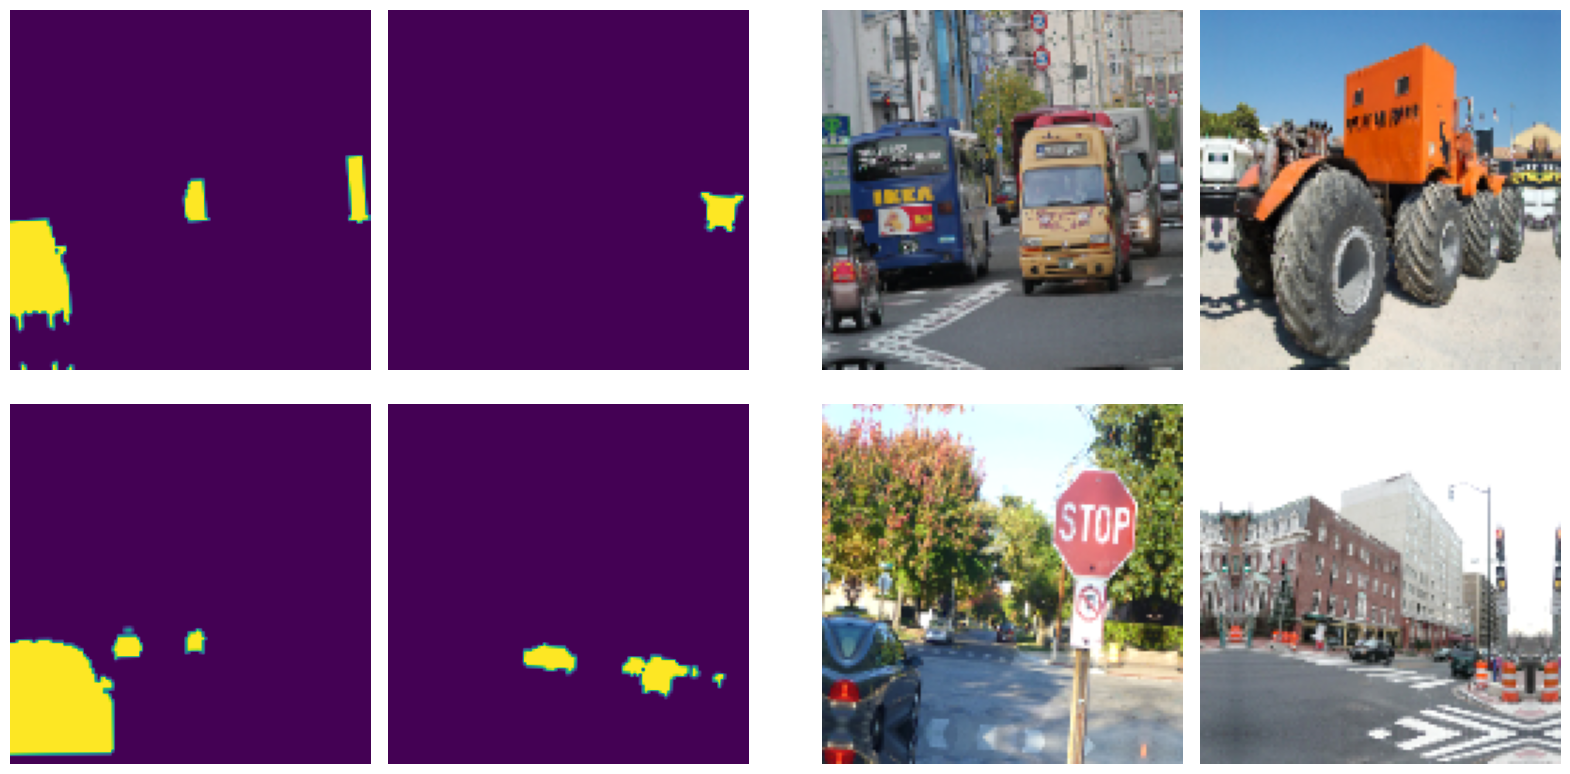

In [36]:
visualizeGenerator(train_gen_aug)

In [37]:
model = Unet(input_shape = (128,128,3))
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [38]:
model.compile(optimizer = Adam(learning_rate = learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [39]:
callbacks = [
    ModelCheckpoint(model_folder, verbose = 1, save_best_only = True),
    ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 3),
    CSVLogger(csv_file),
    EarlyStopping(monitor = 'val_loss', patience = 6, restore_best_weights=False)
]

steps_per_epoch = train_dataset_size // batch_size
validation_steps = val_dataset_size // batch_size

In [40]:
history = model.fit(
    train_gen_aug,
    validation_data = val_gen_aug,
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    callbacks = callbacks
)

Epoch 1/30
3062/3062 [==============================] - ETA: 0s - loss: 0.2188 - accuracy: 0.9324
Epoch 1: val_loss improved from inf to 0.19346, saving model to .\model_file


INFO:tensorflow:Assets written to: .\model_file\assets


INFO:tensorflow:Assets written to: .\model_file\assets


3062/3062 [==============================] - 289s 91ms/step - loss: 0.2188 - accuracy: 0.9324 - val_loss: 0.1935 - val_accuracy: 0.9370 - lr: 1.0000e-04
Epoch 2/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1907 - accuracy: 0.9362
Epoch 2: val_loss improved from 0.19346 to 0.18073, saving model to .\model_file


INFO:tensorflow:Assets written to: .\model_file\assets


INFO:tensorflow:Assets written to: .\model_file\assets


3062/3062 [==============================] - 274s 89ms/step - loss: 0.1907 - accuracy: 0.9362 - val_loss: 0.1807 - val_accuracy: 0.9377 - lr: 1.0000e-04
Epoch 3/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1826 - accuracy: 0.9366
Epoch 3: val_loss improved from 0.18073 to 0.16379, saving model to .\model_file


INFO:tensorflow:Assets written to: .\model_file\assets


INFO:tensorflow:Assets written to: .\model_file\assets


3062/3062 [==============================] - 272s 89ms/step - loss: 0.1826 - accuracy: 0.9366 - val_loss: 0.1638 - val_accuracy: 0.9403 - lr: 1.0000e-04
Epoch 4/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.9372
Epoch 4: val_loss improved from 0.16379 to 0.16293, saving model to .\model_file


INFO:tensorflow:Assets written to: .\model_file\assets


INFO:tensorflow:Assets written to: .\model_file\assets


3062/3062 [==============================] - 272s 89ms/step - loss: 0.1773 - accuracy: 0.9372 - val_loss: 0.1629 - val_accuracy: 0.9389 - lr: 1.0000e-04
Epoch 5/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.9374
Epoch 5: val_loss did not improve from 0.16293
3062/3062 [==============================] - 265s 86ms/step - loss: 0.1727 - accuracy: 0.9374 - val_loss: 0.1662 - val_accuracy: 0.9405 - lr: 1.0000e-04
Epoch 6/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.9378
Epoch 6: val_loss improved from 0.16293 to 0.16021, saving model to .\model_file


INFO:tensorflow:Assets written to: .\model_file\assets


INFO:tensorflow:Assets written to: .\model_file\assets


3062/3062 [==============================] - 272s 89ms/step - loss: 0.1687 - accuracy: 0.9378 - val_loss: 0.1602 - val_accuracy: 0.9382 - lr: 1.0000e-04
Epoch 7/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1636 - accuracy: 0.9385
Epoch 7: val_loss did not improve from 0.16021
3062/3062 [==============================] - 266s 87ms/step - loss: 0.1636 - accuracy: 0.9385 - val_loss: 0.1607 - val_accuracy: 0.9364 - lr: 1.0000e-04
Epoch 8/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1601 - accuracy: 0.9389
Epoch 8: val_loss improved from 0.16021 to 0.15032, saving model to .\model_file


INFO:tensorflow:Assets written to: .\model_file\assets


INFO:tensorflow:Assets written to: .\model_file\assets


3062/3062 [==============================] - 274s 90ms/step - loss: 0.1601 - accuracy: 0.9389 - val_loss: 0.1503 - val_accuracy: 0.9436 - lr: 1.0000e-04
Epoch 9/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9398
Epoch 9: val_loss improved from 0.15032 to 0.14930, saving model to .\model_file


INFO:tensorflow:Assets written to: .\model_file\assets


INFO:tensorflow:Assets written to: .\model_file\assets


3062/3062 [==============================] - 276s 90ms/step - loss: 0.1571 - accuracy: 0.9398 - val_loss: 0.1493 - val_accuracy: 0.9398 - lr: 1.0000e-04
Epoch 10/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9408
Epoch 10: val_loss improved from 0.14930 to 0.13652, saving model to .\model_file


INFO:tensorflow:Assets written to: .\model_file\assets


INFO:tensorflow:Assets written to: .\model_file\assets


3062/3062 [==============================] - 273s 89ms/step - loss: 0.1523 - accuracy: 0.9408 - val_loss: 0.1365 - val_accuracy: 0.9450 - lr: 1.0000e-04
Epoch 11/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1481 - accuracy: 0.9415
Epoch 11: val_loss did not improve from 0.13652
3062/3062 [==============================] - 266s 87ms/step - loss: 0.1481 - accuracy: 0.9415 - val_loss: 0.1379 - val_accuracy: 0.9428 - lr: 1.0000e-04
Epoch 12/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.9423
Epoch 12: val_loss did not improve from 0.13652
3062/3062 [==============================] - 265s 87ms/step - loss: 0.1441 - accuracy: 0.9423 - val_loss: 0.1535 - val_accuracy: 0.9377 - lr: 1.0000e-04
Epoch 13/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.9436
Epoch 13: val_loss improved from 0.13652 to 0.13293, saving model to .\model_file


INFO:tensorflow:Assets written to: .\model_file\assets


INFO:tensorflow:Assets written to: .\model_file\assets


3062/3062 [==============================] - 273s 89ms/step - loss: 0.1406 - accuracy: 0.9436 - val_loss: 0.1329 - val_accuracy: 0.9462 - lr: 1.0000e-04
Epoch 14/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.9437
Epoch 14: val_loss did not improve from 0.13293
3062/3062 [==============================] - 266s 87ms/step - loss: 0.1382 - accuracy: 0.9437 - val_loss: 0.1342 - val_accuracy: 0.9476 - lr: 1.0000e-04
Epoch 15/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.9449
Epoch 15: val_loss did not improve from 0.13293
3062/3062 [==============================] - 265s 87ms/step - loss: 0.1342 - accuracy: 0.9449 - val_loss: 0.1341 - val_accuracy: 0.9457 - lr: 1.0000e-04
Epoch 16/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.9459
Epoch 16: val_loss improved from 0.13293 to 0.12754, saving model to .\model_file


INFO:tensorflow:Assets written to: .\model_file\assets


INFO:tensorflow:Assets written to: .\model_file\assets


3062/3062 [==============================] - 272s 89ms/step - loss: 0.1319 - accuracy: 0.9459 - val_loss: 0.1275 - val_accuracy: 0.9481 - lr: 1.0000e-04
Epoch 17/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.9474
Epoch 17: val_loss did not improve from 0.12754
3062/3062 [==============================] - 264s 86ms/step - loss: 0.1280 - accuracy: 0.9474 - val_loss: 0.1334 - val_accuracy: 0.9458 - lr: 1.0000e-04
Epoch 18/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.9479
Epoch 18: val_loss did not improve from 0.12754
3062/3062 [==============================] - 266s 87ms/step - loss: 0.1255 - accuracy: 0.9479 - val_loss: 0.1367 - val_accuracy: 0.9452 - lr: 1.0000e-04
Epoch 19/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1234 - accuracy: 0.9490
Epoch 19: val_loss improved from 0.12754 to 0.12224, saving model to .\model_file


INFO:tensorflow:Assets written to: .\model_file\assets


INFO:tensorflow:Assets written to: .\model_file\assets


3062/3062 [==============================] - 279s 91ms/step - loss: 0.1234 - accuracy: 0.9490 - val_loss: 0.1222 - val_accuracy: 0.9492 - lr: 1.0000e-04
Epoch 20/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1199 - accuracy: 0.9501
Epoch 20: val_loss did not improve from 0.12224
3062/3062 [==============================] - 267s 87ms/step - loss: 0.1199 - accuracy: 0.9501 - val_loss: 0.1312 - val_accuracy: 0.9484 - lr: 1.0000e-04
Epoch 21/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1178 - accuracy: 0.9509
Epoch 21: val_loss did not improve from 0.12224
3062/3062 [==============================] - 267s 87ms/step - loss: 0.1178 - accuracy: 0.9509 - val_loss: 0.1324 - val_accuracy: 0.9501 - lr: 1.0000e-04
Epoch 22/30
3062/3062 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.9524
Epoch 22: val_loss did not improve from 0.12224
3062/3062 [==============================] - 267s 87ms/step - loss: 0.1145 - accuracy: 0.9524 - val_

INFO:tensorflow:Assets written to: .\model_file\assets


INFO:tensorflow:Assets written to: .\model_file\assets


3062/3062 [==============================] - 274s 90ms/step - loss: 0.1003 - accuracy: 0.9578 - val_loss: 0.1093 - val_accuracy: 0.9557 - lr: 1.0000e-05
Epoch 24/30
3062/3062 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.9585
Epoch 24: val_loss did not improve from 0.10930
3062/3062 [==============================] - 269s 88ms/step - loss: 0.0979 - accuracy: 0.9585 - val_loss: 0.1273 - val_accuracy: 0.9519 - lr: 1.0000e-05
Epoch 25/30
3062/3062 [==============================] - ETA: 0s - loss: 0.0961 - accuracy: 0.9594
Epoch 25: val_loss did not improve from 0.10930
3062/3062 [==============================] - 271s 89ms/step - loss: 0.0961 - accuracy: 0.9594 - val_loss: 0.1306 - val_accuracy: 0.9501 - lr: 1.0000e-05
Epoch 26/30
3062/3062 [==============================] - ETA: 0s - loss: 0.0957 - accuracy: 0.9595
Epoch 26: val_loss did not improve from 0.10930
3062/3062 [==============================] - 268s 88ms/step - loss: 0.0957 - accuracy: 0.9595 - val_

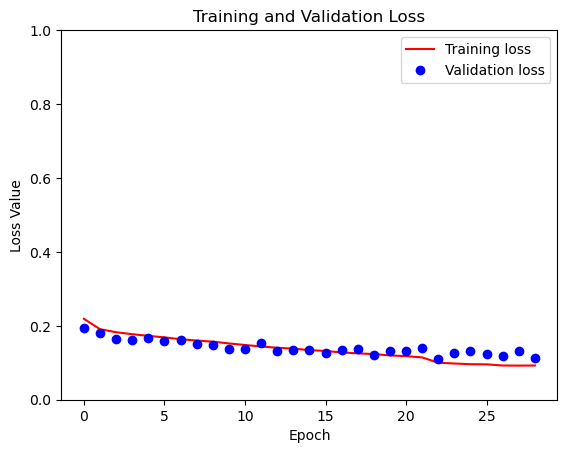

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [17]:
loaded_model = tf.keras.models.load_model(model_folder)

In [21]:
single_image_test_generator = dataGeneratorCoco(val_images, classes, val_coco, folder,
                            input_image_size, 1, val_mode, mask_type)

1/1 [==============================] - 0s 23ms/step


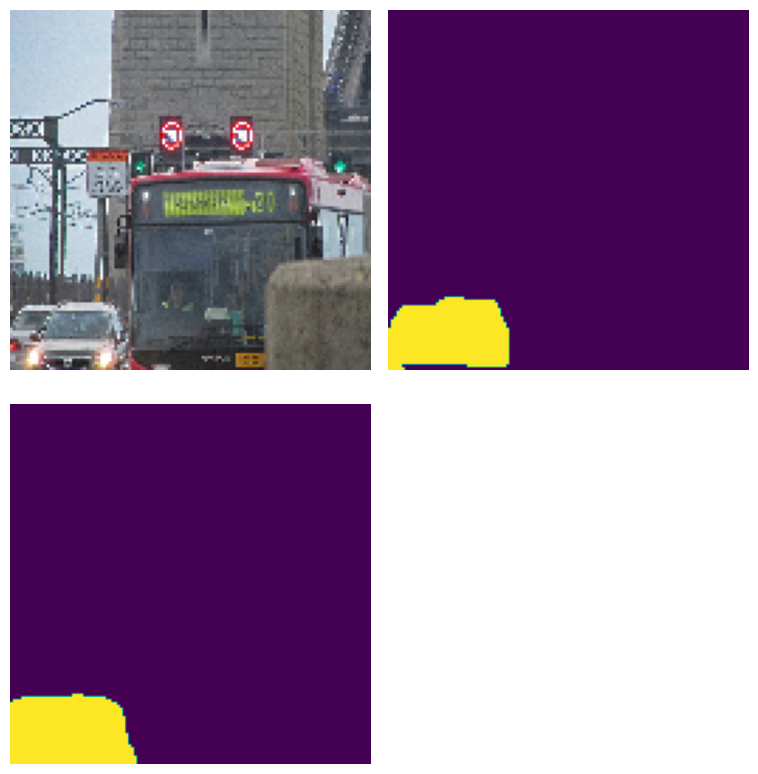

In [54]:
test_model(single_image_test_generator, loaded_model)

1/1 [==============================] - 0s 15ms/step


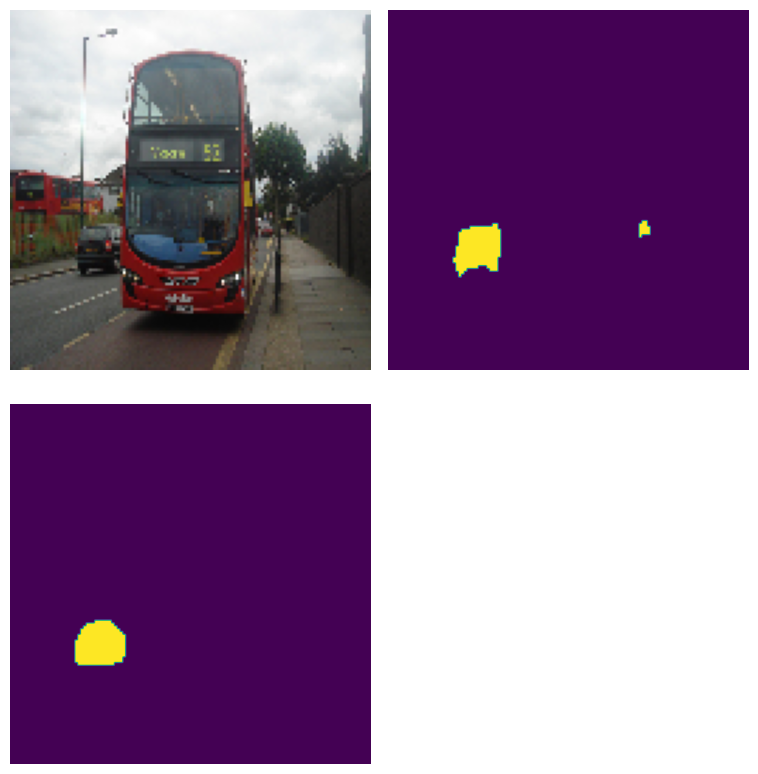

In [64]:
test_model(single_image_test_generator, model)

In [22]:
def get_all_predicts(gen, model, batch_size):

    predicted_masks_list = []
    true_masks_list = []  # true labels

    num_samples = val_dataset_size

    # Loop over the dataset in batches
    for i in range(0, num_samples, batch_size):
        # Get a batch of images and masks from the generator
        batch_images, batch_masks = next(gen)

        # Predict masks for the batch of images
        batch_predicted_masks = model.predict(batch_images) > 0.4

        # Append the predicted masks and true masks to the lists
        predicted_masks_list.append(batch_predicted_masks)
        true_masks_list.append(batch_masks)

    return predicted_masks_list, true_masks_list

In [23]:
def plot_confusion_matrix(predicted_masks, true_masks):
    
    true_masks_array = np.concatenate(true_masks)
    predicted_masks_array = np.concatenate(predicted_masks)
    
    true_labels = true_masks_array.flatten()
    predicted_labels = predicted_masks_array.flatten()

    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot()
    plt.show()

In [54]:
predict_generator = dataGeneratorCoco(val_images, classes, val_coco, folder,
                            input_image_size, batch_size, val_mode, mask_type)

predicted_masks_list, true_masks_list = get_all_predicts(predict_generator, model ,batch_size)

1/1 [==============================] - 0s 20ms/step


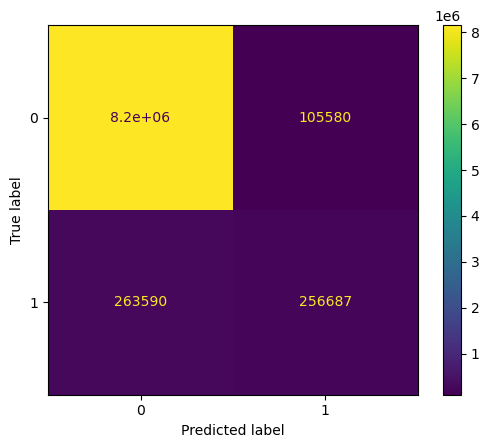

In [55]:
plot_confusion_matrix(predicted_masks_list, true_masks_list)